# 2-way Distal Admixture Tunisia Neolithic

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
# Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
os.sys.path.append(path)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-e-16-233.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


### Do qpAdm Function Imports and Definitions

In [2]:
from python.run_qpadm import qpAdm_run, get_meta_ind_table, modifiy_iid_files, set_iids_to_label
from python.plot_qpadm import plot_qpadm

### Parameters for qpAdm_run are set there!
a12 = ["Mota", "Ust_Ishim", "Kostenki14", "GoyetQ116-1", "Vestonice16", "MA1",
           "ElMiron", "Villabruna", "EHG", "CHG", "Natufian",
           "Levant_N"] # List of ancient European populations for right populations
distal = ["Anatolia_N", "WHG", "Steppe_EMBA", 
          "Iran_N", "Morocco_EN.SG"]
print(f"# Anc_Euro: {len(a12)} populations")
print(f"# Distal sources:{len(distal)} populations")

# Anc_Euro: 12 populations
# Distal sources:5 populations


# 1) Get Dataframe with anno clusters

In [3]:
vrs = "49.2"

df = get_meta_ind_table(path_ind = f"./eigenstrat/combined/punic.v{vrs}.ind",
                        path_anno = f"/n/groups/reich/hringbauer/Data/v{vrs}.anno.csv",
                        min_snp = 30000)

Filtering to 1311/1313
Loaded 1311 Individuals
Filtered to 1264 Individuals based on #SNP covered> 30000
Filtered to 1175 Individuals based on duplicates.


### 1b) Optional: Screen for population labels

In [45]:
df[df["clst"].str.contains("Morocco")]["clst"].value_counts()

Morocco_Iberomaurusian                   6
Morocco_LN.SG                            3
Morocco_EN.SG                            3
Morocco_unknown.SG                       1
Morocco_Iberomaurusian_sibling.TAF011    1
Name: clst, dtype: int64

### Prepare .ind File with Tunisia individuals seperated out

In [5]:
### Populations to overwrite. Typically because they have the ".SG" label
ind_merged = f"./eigenstrat/combined/punic.v{vrs}.ind"          # What .ind to load
ind_modified = f"./eigenstrat/combined/punic.v{vrs}.tunisia_N_ind.ind"    # Where to save the modified version to
df_ind = pd.read_csv(ind_merged, delim_whitespace=True, header=None)
df_ind.columns=["iid", "sex", "clst"]
print(f"Loaded {len(df_ind)} Individuals")

modifiy_iid_files(df_ind, pops_overwrite=["Tunisia_N"], 
                  pops_overwrite12=[],
                  ind_modified = ind_modified)

Loaded 1313 Individuals
Found 4 Matches
Tunisia_N    4
Name: clst, dtype: int64
Saved 1313 Individuals to ./eigenstrat/combined/punic.v49.2.tunisia_N_ind.ind


### Run distal Models for Tunisia

### Test Run for single Individual

In [21]:
%%time

target = "I20825"  
sources = distal
leftpops = [target] + sources
rightpops = a12

qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops) + ".log", 
          input_folder = "./eigenstrat/combined/", 
          input_file = "punic.v49.0",
          par_file_folder = "./parfiles/", 
          input_ind_suff = ".tunisia_N_ind", 
          output_folder = "./output/qpAdm/v49.0/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=True)

Runtime: 96.386997
CPU times: user 5.56 ms, sys: 8.97 ms, total: 14.5 ms
Wall time: 1min 36s


0

## Run all single Indivdiuals

In [23]:
sources = distal
rightpops = a12

iids = df[df["clst"].str.contains("Tunisia_N")]["iid"].values
print(f"Found {len(iids)} Individuals to run...")

for target in iids:
    leftpops = [target] + sources
    qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
              output_file = ".".join(leftpops) + ".log", 
              input_folder = "./eigenstrat/combined/", 
              input_file = "punic.v49.0",
              par_file_folder = "./parfiles/", 
              input_ind_suff = ".tunisia_N_ind", 
              output_folder = "./output/qpAdm/v49.0/tunisia_n_distal/", 
              path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
              all_snps=True)

Found 8 Individuals to run...
Runtime: 99.077401
Runtime: 95.819268
Runtime: 95.919909
Runtime: 98.362426
Runtime: 119.191381
Runtime: 95.193831
Runtime: 95.467838
Runtime: 98.731012


# Run two way models for shift within Tunisia N

In [7]:
### Define Individuals that shifted
iids_old = ["I20824", "I20825", "I22580", "I22866"] # The four dated Individuals
iids_shift = ["I22852"]
path_merged = f"./eigenstrat/combined/punic.v{vrs}.ind"

df_ind = pd.read_csv(path_merged, delim_whitespace=True, header=None)
df_ind.columns=["iid", "sex", "clst"]
print(f"Loaded {len(df_ind)} Individuals")

set_iids_to_label(df_ind, iids_old, label_new="Tunisia_Old",
                    pops_overwrite12=[], savepath="")
set_iids_to_label(df_ind, iids_shift, label_new="Tunisia_Shift",
                    pops_overwrite12=[], savepath=f"./eigenstrat/combined/punic.v{vrs}.tunisia_N_shft.ind")

Loaded 1313 Individuals
Overwriting 4 Individuals
Overwriting 1 Individuals
Saved 1313 Individuals to ./eigenstrat/combined/punic.v49.2.tunisia_N_shft.ind


# Run qpAdm analysis for shift

### Run a single Model

In [37]:
target = "Tunisia_Shift"  

s2s =  ["Spain_EN", "France_EN", "Israel_C", 'ElMiron', 'Villabruna', 
        'EHG','CHG', 
        'Natufian', 'Levant_N', "Italy_Sardinia_N", 
        "Anatolia_N", "Steppe_MLBA", "Iran_N", "Israel_MLBA", "Lebanon_MBA.SG"]

for pop in s2: #a12
    print(f"Running {pop}...")
    a12t = a12.copy()
    if pop in 12t:  ### Remove if needed
        a12t.remove(pop)

    sources = ["Tunisia_Old", pop] 

    leftpops = [target] + sources
    rightpops = a12t

    qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
              output_file = ".".join(leftpops) + "", 
              input_folder = "./eigenstrat/combined/", 
              input_file = f"punic.v{vrs}",
              par_file_folder = "./parfiles/", 
              input_ind_suff = ".tunisia_N_shft", 
              output_folder = f"./output/qpAdm/v{vrs}/tun_n_shift/", 
              path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
              all_snps=True)

Running Lebanon_MBA.SG...
Runtime: 57.333229


# Plot Results

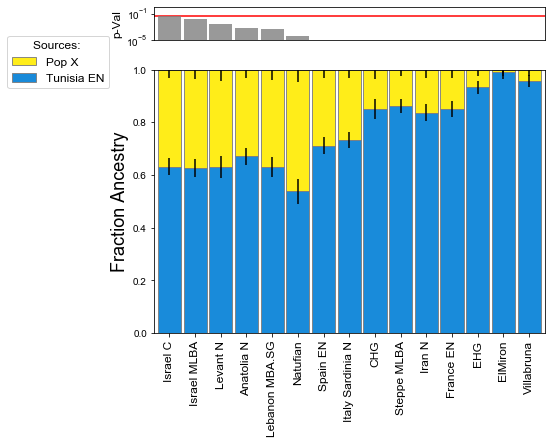

In [23]:
### Load the ancient Individual Label Data
s1 = "Tunisia_Old"
t = "Tunisia_Shift"

s2s =  ['ElMiron', 'Villabruna', 'EHG','CHG', 'Natufian', 'Levant_N', "Italy_Sardinia_N", 
        "Anatolia_N", "Steppe_MLBA", "Iran_N", "Israel_MLBA", "Lebanon_MBA.SG",
        "Spain_EN", "France_EN", "Israel_C"] 

paths = [".".join([t, s1, s2]) for s2 in s2s]

dir_path = f"./output/qpAdm/v{vrs}/tun_n_shift/"
save_path = "" # ./figures/qpAdm/v44/4way_Canaanite.pdf
c = ["#007ED6", "#FFEC00"]

xlabels = [s.replace("_", " ") for s in s2s]
plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path,
           xlabels=xlabels, sort_p=True, labels=["Tunisia EN", "Pop X"],
           best=False, pval_lim = [1e-5,1], figsize=(7,6), bw=0.9, lw=1.5, 
           fs=12, c=c, ec="gray", l_pos=(-0.1, 1.15))

# Test the same for Morocco Individuals

In [31]:
target = "Morocco_LN.SG"  

s2s =  ["Spain_EN", "France_EN", "Israel_C", 'ElMiron', 'Villabruna', 
        'EHG','CHG', 'Natufian', 'Levant_N', "Italy_Sardinia_N", 
        "Anatolia_N", "Steppe_MLBA", "Iran_N", "Israel_MLBA", "Lebanon_MBA.SG"]

for pop in s2s: #a12
    print(f"Running {pop}...")
    a12t = a12.copy()
    if pop in a12t:  ### Remove if needed
        a12t.remove(pop)

    sources = ["Morocco_EN.SG", pop] 
    leftpops = [target] + sources
    rightpops = a12t

    qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
              output_file = ".".join(leftpops) + "", 
              input_folder = "./eigenstrat/combined/", 
              input_file = f"punic.v{vrs}",
              par_file_folder = "./parfiles/", 
              input_ind_suff = ".tunisia_N_shft", 
              output_folder = f"./output/qpAdm/v{vrs}/mor_n_shift/", 
              path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
              all_snps=True)

Running Spain_EN...
Runtime: 59.870062
Running France_EN...
Runtime: 60.430316
Running Israel_C...
Runtime: 62.284293
Running ElMiron...
Runtime: 59.046171
Running Villabruna...
Runtime: 60.280983
Running EHG...
Runtime: 60.362193
Running CHG...
Runtime: 60.560601
Running Natufian...
Runtime: 59.878148
Running Levant_N...
Runtime: 58.083587
Running Italy_Sardinia_N...
Runtime: 63.023398
Running Anatolia_N...
Runtime: 62.426632
Running Steppe_MLBA...
Runtime: 62.810406
Running Iran_N...
Runtime: 61.549991
Running Israel_MLBA...
Runtime: 63.641934
Running Lebanon_MBA.SG...
Runtime: 60.018659


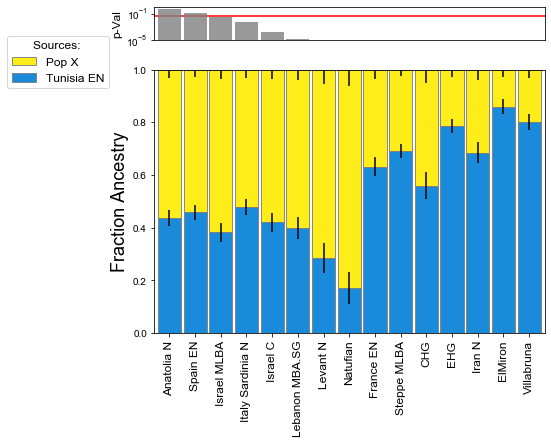

In [34]:
### Load the ancient Individual Label Data
s1 = "Morocco_EN.SG" 
t = "Morocco_LN.SG" 

s2s =  ['ElMiron', 'Villabruna', 'EHG','CHG', 'Natufian', 'Levant_N', "Italy_Sardinia_N", 
        "Anatolia_N", "Steppe_MLBA", "Iran_N", "Israel_MLBA", "Lebanon_MBA.SG",
        "Spain_EN", "France_EN", "Israel_C"] 

paths = [".".join([t, s1, s2]) for s2 in s2s]

dir_path = f"./output/qpAdm/v{vrs}/mor_n_shift/"
save_path = "" # ./figures/qpAdm/v44/4way_Canaanite.pdf
c = ["#007ED6", "#FFEC00"]

xlabels = [s.replace("_", " ") for s in s2s]
plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path,
           xlabels=xlabels, sort_p=True, labels=["Tunisia EN", "Pop X"],
           best=False, pval_lim = [1e-5,1], figsize=(7,6), bw=0.9, lw=1.5, 
           fs=12, c=c, ec="gray", l_pos=(-0.1, 1.15))

# Test Guanche 3-way Model

In [39]:
%%time

target = "CanaryIslands_Guanche.SG" # "Algeria_IA"  
sources = ["Morocco_EN.SG", "Anatolia_N", "Israel_C"]
leftpops = [target] + sources
rightpops = a12

qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops),
          input_folder = "./eigenstrat/combined/", 
          input_file = f"punic.v{vrs}",
          par_file_folder = "./parfiles/", 
          input_ind_suff = ".tunisia_N_ind", 
          output_folder = f"./output/qpAdm/v{vrs}/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=True)

Runtime: 68.349602
CPU times: user 3.64 ms, sys: 10.1 ms, total: 13.7 ms
Wall time: 1min 8s


0

# Tunisia_Old and Morocco_Iberomaurusian 1 way model:
p-value ~0.01!!

In [46]:
%%time

target = "Tunisia_Old" 
sources = ["Morocco_Iberomaurusian"]
leftpops = [target] + sources
rightpops = a12

qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops),
          input_folder = "./eigenstrat/combined/", 
          input_file = f"punic.v{vrs}",
          par_file_folder = "./parfiles/", 
          input_ind_suff = ".tunisia_N_shft", 
          output_folder = f"./output/qpAdm/v{vrs}/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=True)

Runtime: 54.686758
CPU times: user 5.54 ms, sys: 6.55 ms, total: 12.1 ms
Wall time: 54.7 s


0

# Tunisia LN and Morocco LN not cladal!
p-Value: 1.11957036e-05

In [48]:
%%time

target = "Tunisia_Shift" 
sources = ["Morocco_LN.SG"]
leftpops = [target] + sources
rightpops = a12

qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops),
          input_folder = "./eigenstrat/combined/", 
          input_file = f"punic.v{vrs}",
          par_file_folder = "./parfiles/", 
          input_ind_suff = ".tunisia_N_shft", 
          output_folder = f"./output/qpAdm/v{vrs}/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=True)

Runtime: 54.577098
CPU times: user 6.28 ms, sys: 7.3 ms, total: 13.6 ms
Wall time: 54.6 s


0

# Area 51